Data Berhasil Diload: 2000 baris.

--- SEDANG MELATIH MODEL UNTUK TARGET: Ethanol_Yield ---
Juara Model untuk Ethanol_Yield: 2. Random Forest (R2: 0.9599)

[HASIL KOMPARASI - YIELD]
                     Model  R2 Score       RMSE        MAE
1         2. Random Forest  0.959926   3.034519   2.196803
2     3. Gradient Boosting  0.905553   4.658600   3.229415
4   5. K-Nearest Neighbors  0.811054   6.589151   4.382285
3  4. Support Vector (SVR)  0.755978   7.488167   4.775819
0     1. Linear Regression  0.120881  14.212965  10.168415

--- SEDANG MELATIH MODEL UNTUK TARGET: Energy_Consumption ---
Juara Model untuk Energy_Consumption: 3. Gradient Boosting (R2: 0.9962)

[HASIL KOMPARASI - ENERGY]
                     Model  R2 Score         RMSE         MAE
2     3. Gradient Boosting  0.996162   283.393787  217.032544
1         2. Random Forest  0.994430   341.429758  257.440912
4   5. K-Nearest Neighbors  0.971295   775.059106  596.576798
3  4. Support Vector (SVR)  0.949322  1029.840122  57

/tmp/ipython-input-3817781548.py:123: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='R2 Score', y='Model', data=results_yield, ax=axes[0], palette='viridis')
/tmp/ipython-input-3817781548.py:127: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='R2 Score', y='Model', data=results_energy, ax=axes[1], palette='magma')


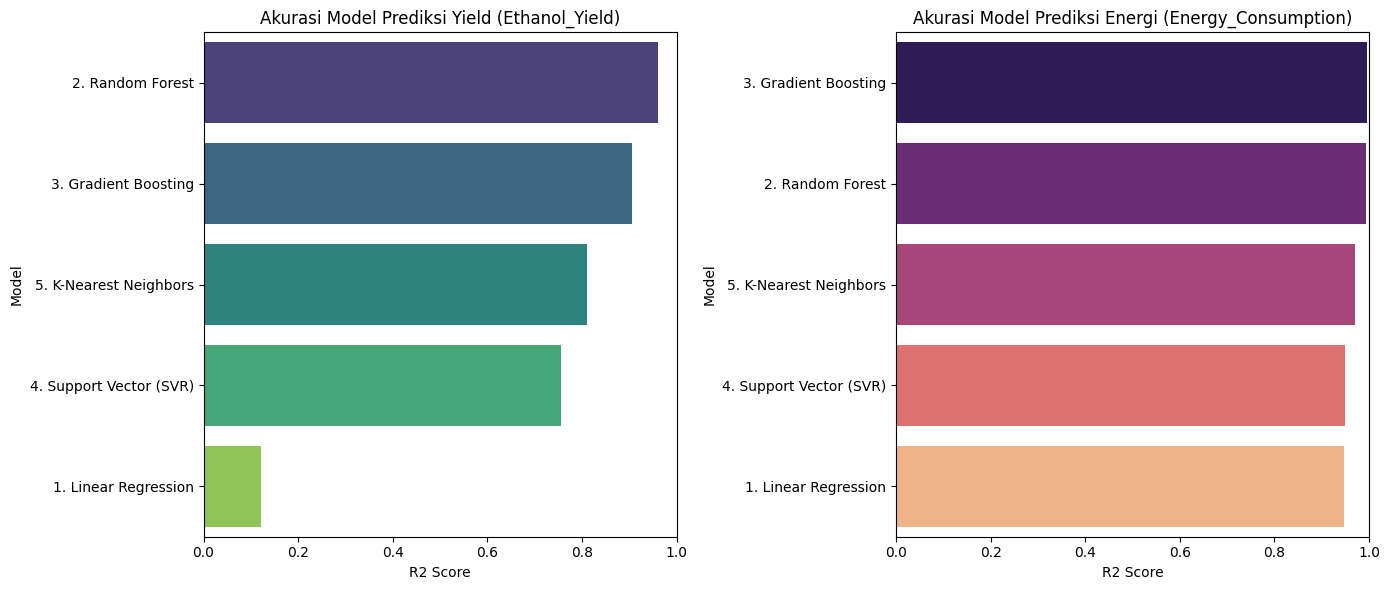


--- MENYIMPAN MODEL TERBAIK ---
Model terbaik berhasil disimpan sebagai file .pkl!
Siap lanjut ke Tahap 3: Optimasi Metaheuristik.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib # Untuk menyimpan model yang sudah dilatih

# Library Machine Learning (Scikit-Learn)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Import 5 Algoritma Berbeda
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

# ==========================================
# KONFIGURASI
# ==========================================
# Ganti nama file sesuai dataset mahasiswa yang didapat
FILE_PATH = '/content/dataset_mhs_10.csv'

# Fitur Input (X) dan Target Output (y)
INPUT_COLS = ['Temperature', 'pH', 'Fermentation_Time', 'Substrate_Conc', 'Agitation_Speed']
TARGET_YIELD = 'Ethanol_Yield'
TARGET_ENERGY = 'Energy_Consumption'

# ==========================================
# FUNGSI PELATIHAN & EVALUASI
# ==========================================
def train_and_compare_models(df, target_col):
    """
    Fungsi ini akan melatih 5 model berbeda untuk satu target tertentu
    dan mengembalikan tabel perbandingan performanya.
    """
    print(f"\n--- SEDANG MELATIH MODEL UNTUK TARGET: {target_col} ---")

    # 1. Split Data
    X = df[INPUT_COLS]
    y = df[target_col]

    # 2. Scaling Data (PENTING untuk SVR dan KNN)
    # Tree-based (RF/GradientBoost) sebenarnya tidak butuh scaling, tapi tidak masalah jika diskalakan.
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Split Train (80%) dan Test (20%)
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

    # 3. Daftar Model
    models = {
        "1. Linear Regression": LinearRegression(),
        "2. Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
        "3. Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
        "4. Support Vector (SVR)": SVR(kernel='rbf', C=100, gamma=0.1), # RBF Kernel untuk non-linear
        "5. K-Nearest Neighbors": KNeighborsRegressor(n_neighbors=5)
    }

    results = []
    trained_models = {}

    # 4. Loop Training
    for name, model in models.items():
        # Train
        model.fit(X_train, y_train)

        # Predict
        y_pred = model.predict(X_test)

        # Evaluasi
        r2 = r2_score(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mae = mean_absolute_error(y_test, y_pred)

        results.append({
            "Model": name,
            "R2 Score": r2,      # Makin dekat 1.0 makin bagus
            "RMSE": rmse,        # Makin kecil makin bagus
            "MAE": mae
        })

        trained_models[name] = model

    # Buat DataFrame Hasil
    df_results = pd.DataFrame(results).sort_values(by='R2 Score', ascending=False)

    # Ambil model juara 1
    best_model_name = df_results.iloc[0]['Model']
    best_model = trained_models[best_model_name]

    print(f"Juara Model untuk {target_col}: {best_model_name} (R2: {df_results.iloc[0]['R2 Score']:.4f})")

    return df_results, best_model, scaler

# ==========================================
# EKSEKUSI UTAMA
# ==========================================

# 1. Load Data
try:
    df = pd.read_csv(FILE_PATH)
    print(f"Data Berhasil Diload: {len(df)} baris.")
except FileNotFoundError:
    print("Error: File CSV tidak ditemukan. Pastikan path sesuai.")
    exit()

# 2. Latih Model untuk YIELD (Maksimasi)
results_yield, model_yield, scaler_yield = train_and_compare_models(df, TARGET_YIELD)
print("\n[HASIL KOMPARASI - YIELD]")
print(results_yield)

# 3. Latih Model untuk ENERGY (Minimasi)
results_energy, model_energy, scaler_energy = train_and_compare_models(df, TARGET_ENERGY)
print("\n[HASIL KOMPARASI - ENERGY]")
print(results_energy)

# ==========================================
# VISUALISASI HASIL (Bar Chart R2 Score)
# ==========================================
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.barplot(x='R2 Score', y='Model', data=results_yield, ax=axes[0], palette='viridis')
axes[0].set_title(f'Akurasi Model Prediksi Yield ({TARGET_YIELD})')
axes[0].set_xlim(0, 1.0)

sns.barplot(x='R2 Score', y='Model', data=results_energy, ax=axes[1], palette='magma')
axes[1].set_title(f'Akurasi Model Prediksi Energi ({TARGET_ENERGY})')
axes[1].set_xlim(0, 1.0)

plt.tight_layout()
plt.show()

# ==========================================
# SIMPAN MODEL TERBAIK (Untuk Tahap Optimasi)
# ==========================================
print("\n--- MENYIMPAN MODEL TERBAIK ---")
# Kita simpan Scaler dan Model agar bisa dipakai di file optimasi nanti
joblib.dump(model_yield, 'model_yield_best.pkl')
joblib.dump(scaler_yield, 'scaler_yield.pkl')
joblib.dump(model_energy, 'model_energy_best.pkl')
joblib.dump(scaler_energy, 'scaler_energy.pkl')

print("Model terbaik berhasil disimpan sebagai file .pkl!")
print("Siap lanjut ke Tahap 3: Optimasi Metaheuristik.")

In [ ]:
pip install pygad pyswarms scikit-learn

In [ ]:
import numpy as np
import pandas as pd
import joblib
import time
import matplotlib.pyplot as plt

# Library Optimasi
import pygad
import pyswarms as ps
import warnings
# Abaikan warning spesifik tentang feature names
warnings.filterwarnings("ignore", message="X does not have valid feature names")
# Atau abaikan semua UserWarning (lebih bersih)
warnings.filterwarnings("ignore", category=UserWarning)

# ==========================================
# 1. LOAD "OTAK BUATAN" (MODEL ML DARI TAHAP 2)
# ==========================================
print("--- MEMUAT MODEL MACHINE LEARNING ---")
try:
    # Memuat Model Prediksi Yield (Maksimasi)
    model_yield = joblib.load('model_yield_best.pkl')
    scaler_yield = joblib.load('scaler_yield.pkl')

    # Memuat Model Prediksi Energi (Minimasi)
    model_energy = joblib.load('model_energy_best.pkl')
    scaler_energy = joblib.load('scaler_energy.pkl')
    print("Sukses: Model ML berhasil dimuat.")
except FileNotFoundError:
    print("Error: File .pkl tidak ditemukan. Jalankan kode Tahap 2 dulu!")
    exit()

# Batasan Fisik Alat (Sesuai Soal)
# Urutan: [Temp, pH, Time, Substrate, RPM]
BOUNDS_MIN = [25, 4.0, 24, 50, 100]
BOUNDS_MAX = [45, 6.0, 72, 200, 500]

# ==========================================
# 2. DEFINISI FUNGSI OBJEKTIF (FITNESS) - REVISI
# ==========================================
def objective_function(solution):
    """
    Input: Array [Temp, pH, Time, Substrate, RPM]
    Output: Nilai Fitness (Semakin tinggi semakin bagus)
    Rumus: Fitness = (Yield) - (Penalty * Energy)
    """
    # 1. Bentuk ulang data untuk prediksi (harus 2D array)
    inputs = np.array([solution])

    # 2. Scaling Input (Karena Model ML dilatih pakai data scaled)
    input_scaled_y = scaler_yield.transform(inputs)
    input_scaled_e = scaler_energy.transform(inputs)

    # 3. Prediksi Menggunakan ML
    pred_yield = model_yield.predict(input_scaled_y)[0]
    pred_energy = model_energy.predict(input_scaled_e)[0]

    # 4. SCALARIZATION (REVISI DI SINI)
    # Bobot energi diturunkan jadi 0.004 agar Fitness Positif
    fitness = pred_yield - (0.004 * pred_energy)

    return fitness

# ==========================================
# 3. ALGORITMA 1: GENETIC ALGORITHM (GA)
# ==========================================
print("\n[1/4] Menjalankan Genetic Algorithm (GA)...")
start_time = time.time()

def fitness_ga(ga_inst, solution, idx):
    val = objective_function(solution)
    return val if val > 0 else 0

ga_instance = pygad.GA(num_generations=50,
                       num_parents_mating=5,
                       fitness_func=fitness_ga,
                       sol_per_pop=20,
                       num_genes=5,
                       gene_space=[{'low': L, 'high': H} for L, H in zip(BOUNDS_MIN, BOUNDS_MAX)],
                       random_seed=42)

ga_instance.run()
sol_ga, fit_ga, _ = ga_instance.best_solution()
time_ga = time.time() - start_time
print(f"   -> GA Selesai. Fitness: {fit_ga:.2f}")

# ==========================================
# 4. ALGORITMA 2: PARTICLE SWARM (PSO)
# ==========================================
print("\n[2/4] Menjalankan Particle Swarm Optimization (PSO)...")
start_time = time.time()

# Pyswarms meminimalkan fungsi, jadi return harus dikali -1
def cost_func_pso(x):
    n_particles = x.shape[0]
    results = []
    for i in range(n_particles):
        results.append(-1 * objective_function(x[i]))
    return np.array(results)

bounds_pso = (np.array(BOUNDS_MIN), np.array(BOUNDS_MAX))
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
optimizer_pso = ps.single.GlobalBestPSO(n_particles=20, dimensions=5, options=options, bounds=bounds_pso)

cost, sol_pso = optimizer_pso.optimize(cost_func_pso, iters=50, verbose=False)
fit_pso = -cost
time_pso = time.time() - start_time
print(f"   -> PSO Selesai. Fitness: {fit_pso:.2f}")

# ==========================================
# 5. ALGORITMA 3: GREY WOLF OPTIMIZER (GWO)
# ==========================================
print("\n[3/4] Menjalankan Grey Wolf Optimizer (GWO)...")
start_time = time.time()

# Class GWO Sederhana (Custom)
class GWO_Optimizer:
    def __init__(self, obj_func, lb, ub, dim, pop_size, max_iter):
        self.obj_func = obj_func
        self.lb = np.array(lb); self.ub = np.array(ub)
        self.dim = dim; self.pop_size = pop_size; self.max_iter = max_iter
        self.positions = np.random.uniform(0, 1, (pop_size, dim)) * (self.ub - self.lb) + self.lb
        self.Alpha_pos = np.zeros(dim); self.Alpha_score = -float("inf")
        self.Beta_pos = np.zeros(dim); self.Beta_score = -float("inf")
        self.Delta_pos = np.zeros(dim); self.Delta_score = -float("inf")

    def optimize(self):
        for l in range(self.max_iter):
            a = 2 - l * ((2) / self.max_iter)
            for i in range(self.pop_size):
                self.positions[i] = np.clip(self.positions[i], self.lb, self.ub)
                fitness = self.obj_func(self.positions[i])
                if fitness > self.Alpha_score:
                    self.Delta_score = self.Beta_score; self.Delta_pos = self.Beta_pos.copy()
                    self.Beta_score = self.Alpha_score; self.Beta_pos = self.Alpha_pos.copy()
                    self.Alpha_score = fitness; self.Alpha_pos = self.positions[i].copy()
                elif fitness > self.Beta_score:
                    self.Delta_score = self.Beta_score; self.Delta_pos = self.Beta_pos.copy()
                    self.Beta_score = fitness; self.Beta_pos = self.positions[i].copy()
                elif fitness > self.Delta_score:
                    self.Delta_score = fitness; self.Delta_pos = self.positions[i].copy()

            for i in range(self.pop_size):
                for j in range(self.dim):
                    r1=np.random.random(); r2=np.random.random(); A1=2*a*r1-a; C1=2*r2
                    D_alpha=abs(C1*self.Alpha_pos[j]-self.positions[i,j]); X1=self.Alpha_pos[j]-A1*D_alpha
                    r1=np.random.random(); r2=np.random.random(); A2=2*a*r1-a; C2=2*r2
                    D_beta=abs(C2*self.Beta_pos[j]-self.positions[i,j]); X2=self.Beta_pos[j]-A2*D_beta
                    r1=np.random.random(); r2=np.random.random(); A3=2*a*r1-a; C3=2*r2
                    D_delta=abs(C3*self.Delta_pos[j]-self.positions[i,j]); X3=self.Delta_pos[j]-A3*D_delta
                    self.positions[i,j]=(X1+X2+X3)/3
        return self.Alpha_pos, self.Alpha_score

gwo = GWO_Optimizer(objective_function, BOUNDS_MIN, BOUNDS_MAX, 5, 20, 50)
sol_gwo, fit_gwo = gwo.optimize()
time_gwo = time.time() - start_time
print(f"   -> GWO Selesai. Fitness: {fit_gwo:.2f}")

# ==========================================
# 6. ALGORITMA 4: ANT COLONY OPTIMIZATION (ACO)
# ==========================================
print("\n[4/4] Menjalankan Ant Colony Optimization (ACO)...")
start_time = time.time()

# Class Continuous ACO Sederhana (ACOR)
class ACO_Continuous:
    def __init__(self, func, lb, ub, dim, ant_count, max_iter, q=0.5, xi=0.85):
        self.func = func
        self.lb = np.array(lb)
        self.ub = np.array(ub)
        self.dim = dim
        self.ant_count = ant_count
        self.max_iter = max_iter
        self.archive_size = ant_count  # Arsip solusi disimpan
        self.q = q  # Intensification factor
        self.xi = xi # Convergence speed

        # Inisialisasi Semut Random
        self.pop = np.random.uniform(0, 1, (ant_count, dim)) * (self.ub - self.lb) + self.lb
        self.fitness = np.zeros(ant_count)

    def optimize(self):
        # Evaluasi awal
        for i in range(self.ant_count):
            self.fitness[i] = self.func(self.pop[i])

        # Sort arsip berdasarkan fitness (descending karena maksimasi)
        idx = np.argsort(self.fitness)[::-1]
        self.pop = self.pop[idx]
        self.fitness = self.fitness[idx]

        for it in range(self.max_iter):
            # Bobot probabilitas pemilihan (Gaussian Kernel)
            w = (1 / (self.q * self.ant_count * np.sqrt(2 * np.pi))) * \
                np.exp(-0.5 * (((np.arange(self.ant_count)) - 1) / (self.q * self.ant_count))**2)
            prob = w / np.sum(w)

            new_pop = np.zeros_like(self.pop)

            for i in range(self.ant_count):
                # Roulette Wheel Selection untuk memilih "Guide" dari arsip
                guide_idx = np.random.choice(np.arange(self.ant_count), p=prob)

                # Hitung Sigma (Standard Deviation) untuk langkah
                sigma = 0
                for k in range(self.ant_count):
                    sigma += np.abs(self.pop[k] - self.pop[guide_idx])
                sigma = self.xi * sigma / (self.ant_count - 1)

                # Gerakkan semut baru
                new_pos = self.pop[guide_idx] + np.random.normal(0, 1, self.dim) * sigma
                new_pop[i] = np.clip(new_pos, self.lb, self.ub)

            # Evaluasi populasi baru
            new_fitness = np.zeros(self.ant_count)
            for i in range(self.ant_count):
                new_fitness[i] = self.func(new_pop[i])

            # Gabungkan populasi lama dan baru, lalu ambil yang terbaik (Elitisme)
            combined_pop = np.vstack((self.pop, new_pop))
            combined_fit = np.concatenate((self.fitness, new_fitness))

            idx_sort = np.argsort(combined_fit)[::-1] # Sort Descending
            self.pop = combined_pop[idx_sort[:self.ant_count]]
            self.fitness = combined_fit[idx_sort[:self.ant_count]]

        return self.pop[0], self.fitness[0]

aco = ACO_Continuous(objective_function, BOUNDS_MIN, BOUNDS_MAX, 5, 20, 50)
sol_aco, fit_aco = aco.optimize()
time_aco = time.time() - start_time
print(f"   -> ACO Selesai. Fitness: {fit_aco:.2f}")

# ==========================================
# 7. REKAPITULASI HASIL (REPORT)
# ==========================================
# Fungsi bantu untuk prediksi detail hasil akhir
def get_detail_prediction(solution):
    inputs = np.array([solution])
    y = model_yield.predict(scaler_yield.transform(inputs))[0]
    e = model_energy.predict(scaler_energy.transform(inputs))[0]
    return y, e

print("\n" + "="*80)
print(f"{'ALGORITMA':<10} | {'FITNESS':<8} | {'YIELD (g/L)':<12} | {'ENERGY (kWh)':<12} | {'SUHU':<6} | {'WAKTU':<6}")
print("-" * 80)

# Update list hasil (Bayes dihapus, ACO ditambah)
results = [
    ("GA", sol_ga, fit_ga, time_ga),
    ("PSO", sol_pso, fit_pso, time_pso),
    ("GWO", sol_gwo, fit_gwo, time_gwo),
    ("ACO", sol_aco, fit_aco, time_aco)
]

best_algo_name = ""
best_algo_score = -999

for name, sol, fit, t in results:
    y_pred, e_pred = get_detail_prediction(sol)
    print(f"{name:<10} | {fit:<8.2f} | {y_pred:<12.2f} | {e_pred:<12.2f} | {sol[0]:<6.1f} | {sol[2]:<6.1f}")

    if fit > best_algo_score:
        best_algo_score = fit
        best_algo_name = name

print("="*80)
print(f"KESIMPULAN: Algoritma terbaik untuk pabrik Anda adalah {best_algo_name}.")
print("Gunakan parameter operasi dari algoritma tersebut untuk laporan akhir.")

--- MEMUAT MODEL MACHINE LEARNING ---
Sukses: Model ML berhasil dimuat.

[1/4] Menjalankan Genetic Algorithm (GA)...
   -> GA Selesai. Fitness: 41.14

[2/4] Menjalankan Particle Swarm Optimization (PSO)...
   -> PSO Selesai. Fitness: 41.31

[3/4] Menjalankan Grey Wolf Optimizer (GWO)...
   -> GWO Selesai. Fitness: 41.21

[4/4] Menjalankan Ant Colony Optimization (ACO)...
   -> ACO Selesai. Fitness: 42.12

ALGORITMA  | FITNESS  | YIELD (g/L)  | ENERGY (kWh) | SUHU   | WAKTU 
--------------------------------------------------------------------------------
GA         | 41.14    | 57.28        | 4034.40      | 31.4   | 42.3  
PSO        | 41.31    | 58.37        | 4267.33      | 31.3   | 44.0  
GWO        | 41.21    | 58.53        | 4329.35      | 33.3   | 40.5  
ACO        | 42.12    | 59.12        | 4251.02      | 33.1   | 41.6  
KESIMPULAN: Algoritma terbaik untuk pabrik Anda adalah ACO.
Gunakan parameter operasi dari algoritma tersebut untuk laporan akhir.
